# Add scrpits

In [1]:
import sys
sys.path.append('C:/Users/asus/text2face/FGTD/scripts')

# Import dependencies

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

In [4]:
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel

In [5]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

C:\Users\asus\anaconda3\envs\fgbtd\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [6]:
# File Constants
OUTPUT_DIR = "C:/Users/asus/text2face/FGTD/dataset/img_align_celeba/" # directory where you have kept the images of celebA dataset

# Data Loading

## Initialize Constants

In [7]:
@dataclass
class Config:
  epochs: int = 151
  image_size: int = 128
  initial_size: int = 96
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  embedding_dim: int = 300 # set to the output dimension of text encoder. for bangla fasttext, it's 300. for sbnltk transformer, it's 768
  reduced_embedding_dim: int = 256 # reduce as required

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
torch.cuda.is_available()

True

In [9]:
cfg = Config()
cfg_dict = asdict(cfg)
# wandb.config.update(cfg_dict)

In [10]:
sentence_encoder = SentenceEncoder(cfg.device)

 - Model preparation 🤩...
FastText(vocab=1071924, vector_size=300, alpha=0.025)


# Initialize Helpers (for images)

In [11]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

## Creating subset of dataset

In [12]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    'C:/Users/asus/text2face/FGTD/dataset/celebA_bangla.csv',  
    image_location=OUTPUT_DIR,
    text_desc_location='C:/Users/asus/text2face/FGTD/dataset/text_1_bn_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'কুচকানো_ভুরু', 'কালো_চুল', 'চশমা', 'লিপস্টিক_পরা', 'গোলাপী_গাল', 'সোজা_চুল', 'ধূসর_চুল', 'মোটা', 'টাক', 'মুখ_কিছুটা_খোলা', 'কানের_দুল_পরা', 'বড়_ঠোঁট', 'ভারী_মেকাপ', 'টাই_পরা', 'দাড়ি_নেই', 'হাসি', 'ডিম্বাকৃতির_চেহারা', 'বাদামী_চুল', 'সামনের চুল কম', 'চোখা_নাক', 'মোছ', 'ঘন_ভ্রু', 'অল্পবয়স্ক', 'উঁচু_গালের_হাড়', 'সোনালী_চুল', 'কপালে_ছড়ানো_চুল', 'ফ্যাকাশে', 'গোটি', 'সরু_চোখ', 'নেকলেস_পরা', 'পুরুষ', 'ঢেউ_খেলানো_চুল', 'জুলফি', 'টুপি_পরা', 'দ্বীত্ব_থুতনি', 'আকর্ষণীয়', 'চোখের_নিচে_কালি', 'বড়_নাক', 'হালকা_দাড়ি', 'Unnamed: 0'}
Number of classes:  40
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing Dataloader output

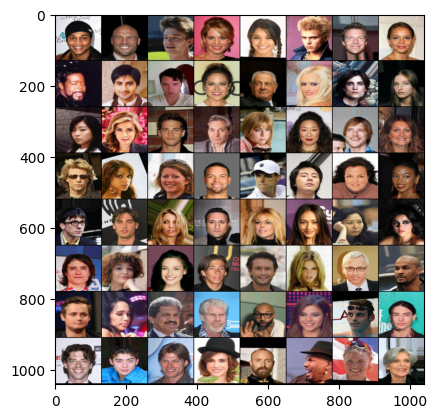

['ছেলেটির ভ্রু কুচকানো ছিল। ছেলেটির চোখের নিচে কালি ছিল। ছেলেটির বড় ঠোঁট ছিল। ছেলেটির বড় নাক ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির উঁচু গালের হাড় ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির দাড়ি নেই। ছেলেটির মুখে ছিল হাসি। ছেলেটির টুপি পরা ছিল। ', 'ভদ্রলোকের মুখে ছিল হালকা দাড়ি। ভদ্রলোকটির মাথায় ছিল টাক। ভদ্রলোকটির বড় নাক ছিল। ভদ্রলোকের উঁচু গালের হাড় ছিল। ভদ্রলোকের মুখ কিছুটা খোলা ছিল। ভদ্রলোকের সরু চোখ ছিল। ভদ্রলোকটির জুলফি ছিল। ভদ্রলোকটির মুখে ছিল হাসি। ', 'ছেলেটির মুখে ছিল হালকা দাড়ি। ছেলেটির সোনালী চুল ছিল। ছেলেটির সোনালী চুল ছিল। ছেলেটির মুখ কিছুটা খোলা ছিল। ছেলেটির সরু চোখ ছিল। ', 'মেয়েটির ভ্রু কুচকানো ছিল। মেয়েটির কপালে ছড়ানো চুল ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির উঁচু গালের হাড় ছিল। মেয়েটির মুখ কিছুটা খোলা ছিল। মেয়েটির চেহারা ডিম্বাকৃতির। মেয়েটির চোখা নাক ছিল। মেয়েটির গোলাপী গাল ছিল। মেয়েটির মুখে ছিল হাসি। মেয়েটির কানে দুল পরা ছিল। মেয়েটির লিপস্টিক পরা ছিল। ', 'মেয়েটির কপালে ছড়ানো চুল ছিল। মেয়েটির সোনালী চুল ছিল। মেয়েটির মুখে ভারী মেকাপ ছিল। মেয়েটির

In [13]:
images, labels, wrong_images = weighted_dataiter._next_data()
show_grid(torchvision.utils.make_grid(images, normalize=True))
print(labels)

# Initialize Weights

In [14]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

## Create Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [15]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 2e-4, betas = (0.5, 0.999))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [16]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, cfg.embedding_dim, cfg.reduced_embedding_dim)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTransp

# Number of parameters in generator

In [17]:
summary(generator,input_size=[(64,100),(64,300)],col_names=("output_size", "num_params"))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [64, 3, 128, 128]         --
├─Sequential: 1-1                        [64, 256]                 --
│    └─Linear: 2-1                       [64, 256]                 77,056
│    └─BatchNorm1d: 2-2                  [64, 256]                 512
│    └─LeakyReLU: 2-3                    [64, 256]                 --
├─Sequential: 1-2                        [64, 3, 128, 128]         --
│    └─ConvTranspose2d: 2-4              [64, 1024, 4, 4]          5,832,704
│    └─BatchNorm2d: 2-5                  [64, 1024, 4, 4]          2,048
│    └─LeakyReLU: 2-6                    [64, 1024, 4, 4]          --
│    └─ConvTranspose2d: 2-7              [64, 512, 8, 8]           8,388,608
│    └─BatchNorm2d: 2-8                  [64, 512, 8, 8]           1,024
│    └─LeakyReLU: 2-9                    [64, 512, 8, 8]           --
│    └─ConvTranspose2d: 2-10             [64, 256, 16, 16]  

# Discriminator Network

## Create Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [18]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder 
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 2e-4, betas = (0.5, 0.999))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)
        
        projected_embed = self.projector(text_embeddings)
        
        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)
        
        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [19]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, cfg.embedding_dim, cfg.reduced_embedding_dim)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

## NoP of Discriminator

In [20]:
summary(discriminator,input_size=[(64,3,128,128),(64,300)],col_names=("output_size", "num_params"))

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [64, 1]                   --
├─Sequential: 1-1                        [64, 1024, 4, 4]          --
│    └─Conv2d: 2-1                       [64, 128, 64, 64]         6,144
│    └─LeakyReLU: 2-2                    [64, 128, 64, 64]         --
│    └─Conv2d: 2-3                       [64, 128, 32, 32]         262,144
│    └─LeakyReLU: 2-4                    [64, 128, 32, 32]         --
│    └─Conv2d: 2-5                       [64, 256, 16, 16]         524,288
│    └─BatchNorm2d: 2-6                  [64, 256, 16, 16]         512
│    └─LeakyReLU: 2-7                    [64, 256, 16, 16]         --
│    └─Conv2d: 2-8                       [64, 512, 8, 8]           2,097,152
│    └─BatchNorm2d: 2-9                  [64, 512, 8, 8]           1,024
│    └─LeakyReLU: 2-10                   [64, 512, 8, 8]           --
│    └─Conv2d: 2-11                      [64, 1024, 4, 4]    

# Specifying Loss Functions

In [21]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

# Plotting output after each epoch

In [22]:
plt_images, plt_labels, _ = weighted_dataiter._next_data()
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()
plt_o_text_embeddings.shape

torch.Size([64, 300])

This is just to generate a batch of text embeddings to be used to plot

In [23]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()
  
    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

# Training

In [24]:
epoch = 0 # don't run this cell when resuming training

In [25]:
checkpoint_path = "C:/Users/asus/text2face/FGTD/Face-GANs/DCGAN/checkpoint/cp.pt" # you can resume training from this checkpoint

In [26]:
generator_path = 'C:/Users/asus/text2face/FGTD/Face-GANs/DCGAN/DCGAN_bftext_generators/'

In [27]:
g_Loss = []
d_Loss = []

In [ ]:
pbar = tqdm()

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)    
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()


    g_Loss.append(torch.mean(torch.FloatTensor(generator_loss)))
    d_Loss.append(torch.mean(torch.FloatTensor(discriminator_loss)))

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))
  
    # wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_loss)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_loss))}, step=epoch+1)

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

    checkpoint = {
    'epoch': epoch,
    'generator_state_dict': generator.state_dict(),
    'generator_optimizer': generator.optimizer.state_dict(),
    'discriminator_state_dict': discriminator.state_dict(),
    'discriminator_optimizer': discriminator.optimizer.state_dict(),
    'g_Losses': g_Loss,
    'd_Losses': d_Loss
    }

    torch.save(checkpoint,checkpoint_path)
    
    if epoch%10 == 0:
        gen_cp = {
        'epoch':epoch,
        'generator_sd':generator.state_dict()
        }
        torch.save(gen_cp,generator_path+str(epoch)+'.pt')

    epoch+=1

pbar.refresh()

# load checkpoint to resume training

In [ ]:
checkpoint = torch.load(checkpoint_path)
generator.load_state_dict(checkpoint['generator_state_dict'])
generator.optimizer.load_state_dict(checkpoint['generator_optimizer'])
discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
discriminator.optimizer.load_state_dict(checkpoint['discriminator_optimizer'])
g_Losses = checkpoint['g_Losses']
d_Losses = checkpoint['d_Losses']
epoch = checkpoint['epoch']
generator.train()
discriminator.train()

plot losses

In [ ]:
plt.plot(checkpoint['d_Losses'],label='discriminator loss')
plt.plot(checkpoint['g_Losses'],label='generator_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper left")
plt.show()

# Output

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['ভদ্রলোকটির আছে বেশ উঁচু গালের হাড়। তার চুল  বাদামী এবং সোজা। সে আছে কুচকানো ভুরু, একটি মুখ কিছুটা খোলা এবং একটি চোখা নাক। লোকটি হয় অল্পবয়স্ক, আকর্ষণীয়, হাসছে। এবং আছে ভারী মেকাপ। সে পরেছে দুল এবং পরা।'])

In [ ]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['ভদ্রলোকটির আছে বেশ উঁচু গালের হাড়। তার চুল বাদামী। সে আছে একটি বড় নাক এবং একটি মুখ কিছুটা খোলা। লোকটি মনে হয় অল্পবয়স্ক এবং হাসছে।।'])

In [ ]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

# Save and Load Model

In [ ]:
PATH = 'C:/Users/asus//text2face/FGTD/Face-GANs/DCGAN/generator.pt'

In [ ]:
torch.save(generator.state_dict(), PATH)

In [ ]:
model = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 512)
model.load_state_dict(torch.load(PATH))
model.cuda()
model.eval()

In [ ]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['তার চুল ঢেউ। সে আছে বড় ঠোঁট, সরু চোখ এবং একটি চোখা নাক। লোকটি দেখায় অল্পবয়স্ক।'])
test_image = model(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))